# Data Generator

Generate the data an add a timestamp

In [456]:
import os
import logging

import pandas as pd
import numpy as np

import h5py
import threading
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

DEP_FEATURE_NAME = 'surf_temp_sqerror'
HDF_LOCK = threading.Lock()
DATE_PATTERN = 'date%Y%m%d'
TIME_PATTERN = 'time%H%M'
KEY_PATTERN = '/{}/{}'.format(DATE_PATTERN, TIME_PATTERN)
STORE_NAME = 'metro_error_data_pro_swe2018.h5'

# Reduce log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

### Environment Variables

In [457]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES
DEPENDENT_FEATURES = ['stn_{}'.format(f) for f in ['dew_point', 'surf_temp']]
ERROR_FEATURES = ['surf_temp_sqerror']

### Data Readers

The functions used for extracting and generating the data

In [458]:

start_time = datetime(2018, 9, 29, 5)
#end_time = datetime(2018, 10, 10, 6)
#end_time = datetime(2018, 10, 29, 6)
count = 0
end_time = datetime(2019, 3, 14, 14)

def define_SSE(df, dep_feature_name):
    if dep_feature_name == 'surf_temp_sqerror':
        df[dep_feature_name] = (df['surf_temp'] - df['stn_surf_temp']) ** 2

def store_path(store_name):
    cwd = os.getcwd()
    return os.path.join(cwd, '{}.h5'.format(store_name))

def read(key, store_name=STORE_NAME):
    key = key.strftime(KEY_PATTERN)
    path = store_name
    with HDF_LOCK:
        with pd.HDFStore(path, 'r') as store:
            if key in store:
                try:
                    df = store.get(key)
                    for dep_feature_name in ERROR_FEATURES:
                        # ['surf_temp_sqerror']:
                        define_SSE(df, dep_feature_name=dep_feature_name)
                except Exception as e:
                    print(e)
                    df = None
                if df is None:
                    return pd.Series([])
                else:
                    return df
            else:
                return pd.Series([])

def gather_training_data(start_time, end_time):
    print('gathering training data from {} until {}'.format(start_time, end_time))
    ref_time = start_time
    m = ref_time.day
    times = []
    dfs = []
    dataTest = {}
    while ref_time <= end_time:
        date = ref_time.strftime("%m/%d/%Y %H:%M:%S")
        val = read(ref_time)
        
        if (val.empty == False):
            for index, row in val.iterrows():
                 if (row['station_id'] in [1417, 1419, 1440, 1433]):
                        row["Date Time"] = date
                        if (row['station_id'], row['forecast_length']) in dataTest:
                            dataTest[(row['station_id'], row['forecast_length'])].append(row)
                        else: 
                            dataTest[(row['station_id'], row['forecast_length'])] = [row]
        ref_time += timedelta(hours=1)

        if (ref_time.day != m):
            m = ref_time.day
            print(m)
    #print(pd.Series(pd.to_datetime(times)))
    #dfs = pd.concat([pd.Series(pd.to_datetime(times)), pd.Series(dfs)], axis=1)
    #x = pd.DataFrame(dfs, columns=val.columns)
#    print(df.memory_usage(index=False).sum())
    return dataTest

df = gather_training_data(start_time, end_time)

gathering training data from 2018-09-29 05:00:00 until 2019-03-14 14:00:00
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [459]:
originalDf = df

In [22]:
len(originalDf)

76

In [23]:
df = df[(1419, 1)]
df = pd.DataFrame(df)
df.set_index("Date Time", inplace=True)

In [24]:
df.head(100)

,AirTemp,DewPoint,RainPrecip,SnowPrecip,SnowPrecipAccumulated,WindSpeed,AirPressure,OctalCloudCoverage,PrecipAmount,station_id,...,air_temp,dew_point,water_amount,snow_sum,forecast_length,stn_surf_temp,stn_dew_point,radiation,shade,surf_temp_sqerror
Date Time,,,,,,,,,,,,,,,,,,,,,
09/29/2018 05:00:00,11.5,6.227035,0.0,-0.0,0.0,7.5,102250.0,6.0,0.0,1419,...,10.8,6.4,0.000,0.0,1,8.600000,6.73,186.336411,1.0,0.032400
09/29/2018 07:00:00,11.8,6.720361,0.0,-0.0,0.0,7.5,102240.0,7.0,0.0,1419,...,12.9,7.4,0.000,0.0,1,11.500000,7.71,675.255920,0.0,0.336400
09/29/2018 09:00:00,11.8,7.519279,0.0,-0.0,0.0,10.4,102180.0,8.0,0.0,1419,...,11.8,8.2,0.000,0.0,1,15.000000,8.20,790.310791,0.0,0.532899
09/29/2018 11:00:00,12.3,6.993432,0.0,-0.0,0.0,10.6,102030.0,8.0,0.0,1419,...,12.6,7.0,0.000,0.0,1,17.500000,7.99,791.719482,0.0,0.025600
09/29/2018 13:00:00,12.8,6.393786,0.0,-0.0,0.0,10.3,101870.0,8.0,0.0,1419,...,12.6,7.0,0.000,0.0,1,15.200000,8.35,681.629700,0.0,0.115600
09/29/2018 15:00:00,12.9,7.357832,0.0,-0.0,0.0,11.6,101700.0,8.0,0.0,1419,...,12.3,7.6,0.000,0.0,1,13.400000,7.63,212.291138,0.5,0.057600
09/29/2018 17:00:00,12.7,7.583966,0.0,-0.0,0.0,10.9,101560.0,8.0,0.0,1419,...,12.2,7.5,0.000,0.0,1,12.500000,7.37,0.000000,1.0,0.001600
09/29/2018 19:00:00,12.1,7.809051,0.0,-0.0,0.0,10.7,101490.0,8.0,0.0,1419,...,11.9,7.6,0.000,0.0,1,12.100000,7.04,0.000000,1.0,0.036100
09/29/2018 21:00:00,12.1,7.008244,0.0,-0.0,0.0,10.1,101380.0,8.0,0.0,1419,...,11.8,6.8,0.000,0.0,1,11.800000,6.89,0.000000,1.0,0.102400


In [25]:
df.shape

(1577, 24)

In [161]:
df.to_csv('station1419_forecast1.csv')

In [379]:
included = np.array(df[INDEPENDENT_FEATURES].notnull().all(axis=1))

float_data = df.loc[included, ['surf_temp_sqerror']].values.astype(np.float)

nmean = nanmean(float_data)
where_are_NaNs = isnan(float_data)
float_data[where_are_NaNs] = 0

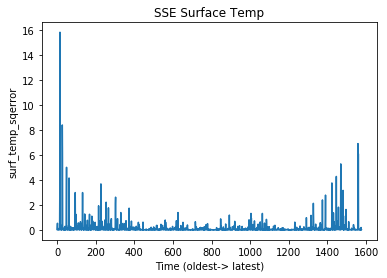

(1577, 2)


In [361]:
%matplotlib inline

import matplotlib.pyplot as plt

input_feature= df.loc[included, ['stn_surf_temp','surf_temp_sqerror']].values
input_data = input_feature

plot_data = input_feature= df.loc[included, INDEPENDENT_FEATURES + ['surf_temp_sqerror']].values
plt.plot(input_feature[:,-1])
plt.title("SSE Surface Temp")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("surf_temp_sqerror")
plt.show()

print(input_data.shape)

In [368]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [378]:
predicted_value= model.predict(X_test)
predicted_value.shape

(523, 1)

In [460]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("data/data_{}.csv".format(str(key)))

    with open("data/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

In [461]:
saver(originalDf)